In [1]:
from symred.S3_projection import S3_projection, QubitTapering, unitary_partitioning_rotations
from symred.symplectic_form import *
from symred.utils import exact_gs_energy
from symred.utils import gf2_gaus_elim, gf2_basis_for_gf2_rref
from symred.chem import FermionicHamilt, FermioniCC, PySCFDriver, geometry_from_pubchem
from openfermion import get_fermion_operator, jordan_wigner, hermitian_conjugated, QubitOperator
from functools import reduce
import json

In [2]:
class CS_VQE_LW(S3_projection):
    """ A lightweight CS-VQE implementation in which we choose an arbitrary
    Pauli Z-basis and project in accordance with it. Can be interpretted as
    CS-VQE with the noncontextual set taken as the diagonal Hamiltonian terms.

    Second-order-response-corrected VQE... identify the independent Z-basis
    that maxises the SOR objective function
    """
    def __init__(self, 
            operator: PauliwordOp,
            ref_state: np.array,
            target_sqp: str = 'Z',
            basis_weighting_operator=None):
        self.operator = operator
        self.ref_state = ref_state
        self.target_sqp = target_sqp
        if basis_weighting_operator is None:
            self.basis_weighting_operator = operator
        else:
            self.basis_weighting_operator = basis_weighting_operator

    def project_onto_subspace(self, 
            basis: StabilizerOp,
            aux_operator: PauliwordOp = None
        ) -> PauliwordOp:
        """ Project the operator in accordance with the supplied basis
        """
        # define the operator to be projected (aux_operator faciliates ansatze to be projected)
        if aux_operator is not None:
            operator_to_project = aux_operator.copy()
        else:
            operator_to_project = self.operator.copy()
        
        # instantiate as StabilizerOp to ensure algebraic independence and coefficients are +/-1
        basis = StabilizerOp(
            basis.symp_matrix, 
            np.ones(basis.n_terms, dtype=int), 
            target_sqp=self.target_sqp
        )
        # update symmetry sector in accordance with the reference state
        basis.update_sector(ref_state=self.ref_state)
        
        # instantiate the parent S3_projection class with the stabilizers we are enforcing
        super().__init__(basis, target_sqp=self.target_sqp)
        
        return self.perform_projection(
            operator=operator_to_project
        )

    def basis_score(self, 
            basis: StabilizerOp
        ) -> float:
        """ Evaluate the score of an input basis according 
        to the basis weighting operator, for example:
            - set Hamiltonian cofficients to 1 for unweighted number of commuting terms
            - specify as the SOR Hamiltonian to weight according to second-order response
            - input UCC operator to weight according to coupled-cluster theory <- best performance
            - if None given then weights by Hamiltonian coefficient magnitude
        """
        # mask terms of the weighting operator that are preserved under projection over the basis
        mask_preserved = np.where(np.all(self.basis_weighting_operator.commutes_termwise(basis),axis=1))[0]
        return (
            np.linalg.norm(self.basis_weighting_operator.coeff_vec[mask_preserved]) /
            np.linalg.norm(self.basis_weighting_operator.coeff_vec)
            )

In [3]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
#with open('data/score_data.json', 'r') as infile:
#    scoring_data = json.load(infile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2-_STO-3G_SINGLET', 'BH3_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3

In [208]:
# Set molecule parameters
speciesname = 'H2O_STO-3G_SINGLET'
#print(speciesname in scoring_data)
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = mol_data['basis']
multiplicity = mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))
#geometry = geometry_from_pubchem('N2')

xyz_file = str(len(atoms))+'\n '

for atom, coords in geometry:
    xyz_file += '\n'+atom+'\t'
    xyz_file += '\t'.join(list(map(str, coords)))
#xyz_file = '4\n \nH\t0\t0\t0\nH\t2.45366053071732\t0\t0\nH\t2.45366053071732\t2.45366053071732\t0\nH\t0\t2.45366053071732\t0\n'
print('Molecule geometry:')
print(xyz_file[4:])

Molecule geometry:
O	0	0	0
H	0.952519	0	0
H	-0.246530058	0.9200627021	0


In [209]:
convergence = 1e-6; max_hf_cycles=100_000; ram = 8_000
run_mp2  = True; run_cisd = False; run_ccsd = True; run_fci  = True

pyscf_obj = PySCFDriver(xyz_file,
                        basis,
                        #convergence=convergence,
                        charge=charge,
                        #max_ram_memory=ram,
                        #max_hf_cycles=max_hf_cycles,                   
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)

pyscf_obj.run_pyscf()

print('HF converged?  ', pyscf_obj.pyscf_hf.converged)
print('CCSD converged?', pyscf_obj.pyscf_ccsd.converged)
if run_fci:
    print('FCI converged? ', pyscf_obj.pyscf_fci.converged)
    fci_energy = pyscf_obj.pyscf_fci.e_tot
else:
    fci_energy = None
    
hf_energy = pyscf_obj.pyscf_hf.e_tot
mp2_energy = pyscf_obj.pyscf_mp2.e_tot
ccsd_energy = pyscf_obj.pyscf_ccsd.e_tot

print()
print(f'HF energy: {hf_energy}')
print(f'MP2 energy: {mp2_energy}')
print(f'CCSD energy: {ccsd_energy}')
print(f'FCI energy: {fci_energy}')

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy: -74.96203967838727
MP2 energy: -74.99708201366202
CCSD energy: -75.01073164269077
FCI energy: -75.01084664816946


In [210]:
H_fermion = FermionicHamilt(pyscf_obj.pyscf_hf)
T_fermion = FermioniCC(pyscf_obj.pyscf_ccsd)
H_fermion.build_operator()
T_fermion.build_operator()

n_qubits = H_fermion.n_qubits
print('Number of qubits:', n_qubits)

H = get_fermion_operator(H_fermion.fermionic_molecular_hamiltonian)
T = T_fermion.fermionic_cc_operator
T -= hermitian_conjugated(T)

H_jw = jordan_wigner(H)
T_jw = jordan_wigner(T)

Number of qubits: 14


In [211]:
def QubitOperator_to_dict(op, num_qubits):
    assert(type(op) == QubitOperator)
    op_dict = {}
    term_dict = op.terms
    terms = list(term_dict.keys())

    for t in terms:    
        letters = ['I' for i in range(num_qubits)]
        for i in t:
            letters[i[0]] = i[1]
        p_string = ''.join(letters)        
        op_dict[p_string] = term_dict[t]
         
    return op_dict

H_q = PauliwordOp(QubitOperator_to_dict(H_jw, n_qubits))
T_q = PauliwordOp(QubitOperator_to_dict(T_jw, n_qubits))
T_q.coeff_vec = T_q.coeff_vec.imag

In [212]:
taper_hamiltonian = QubitTapering(H_q)

print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.\n')
print('The symmetry generators are\n')
print(taper_hamiltonian.symmetry_generators)
print('\nand may be rotated via a sequence of Clifford pi/2 rotations\n')
print(taper_hamiltonian.stabilizers.stabilizer_rotations)
print('\nonto the single-qubit Pauli operators\n')
print(taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis())

We are able to taper 4 qubits from the Hamiltonian.

The symmetry generators are

1+0j ZIZIIZZIIZZIIZ +
1+0j IZIZIZIZIZIZIZ +
1+0j IIIIZZIIIIIIZZ +
1+0j IIIIIIIIZZIIII

and may be rotated via a sequence of Clifford pi/2 rotations

[('IIIIIIIIYZIIII', None), ('IIIIYZIIIIIIZZ', None), ('YIZIIZZIIZZIIZ', None), ('IYIZIZIZIZIZIZ', None)]

onto the single-qubit Pauli operators

-1+0j XIIIIIIIIIIIII +
-1+0j IXIIIIIIIIIIII +
-1+0j IIIIXIIIIIIIII +
-1+0j IIIIIIIIXIIIII


In [213]:
hf_array = H_fermion.hf_comp_basis_state
taper_hamiltonian.stabilizers.update_sector(hf_array)
print(f'The symmetry sector corresponding with the single reference {hf_array} is {taper_hamiltonian.stabilizers.coeff_vec}')

The symmetry sector corresponding with the single reference [1 1 1 1 1 1 1 1 1 1 0 0 0 0] is [-1 -1  1  1]


In [214]:
ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
#sor_tap = taper_hamiltonian.taper_it(aux_operator=sor_ham, ref_state=hf_array)
#sor_tap.coeff_vec/=np.linalg.norm(sor_tap.coeff_vec)
ucc_tap = taper_hamiltonian.taper_it(aux_operator=T_q, ref_state=hf_array)
n_taper = taper_hamiltonian.n_taper
tapered_qubits   = taper_hamiltonian.stab_qubit_indices
untapered_qubits = taper_hamiltonian.free_qubit_indices
hf_tapered = taper_hamiltonian.tapered_ref_state

dashes = "------------------------------------------------"
print("Tapering information:")
print(dashes)
print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian')
print('The symmetry basis/sector is:') 
print(taper_hamiltonian.symmetry_generators)
print(f'The tapered Hartree-Fock state is', QuantumState([hf_tapered]))
print(dashes)

Tapering information:
------------------------------------------------
We are able to taper 4 qubits from the Hamiltonian
The symmetry basis/sector is:
-1 ZIZIIZZIIZZIIZ +
-1 IZIZIZIZIZIZIZ +
1 IIIIZZIIIIIIZZ +
1 IIIIIIIIZZIIII
The tapered Hartree-Fock state is  1.0000000000 |1111110000>
------------------------------------------------


In [215]:
cs_vqe_lw = CS_VQE_LW(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap)

In [216]:
ham_tap.n_qubits

10

In [217]:
ucc_sort = ucc_tap.sort(key='magnitude')
ham_sort = ham_tap.sort(key='magnitude')

def stabilizers_by_ucc_term_significance(n_terms):
    preserve = ucc_sort[:n_terms]# + cs_vqe.clique_operator[1]
    ZX_symp = np.hstack([preserve.Z_block, preserve.X_block])
    reduced = gf2_gaus_elim(ZX_symp)
    kernel  = gf2_basis_for_gf2_rref(reduced)
    stabilizers = StabilizerOp(kernel, np.ones(kernel.shape[0]))
    mask_diag = np.where(~np.any(stabilizers.X_block, axis=1))[0]
    return StabilizerOp(stabilizers.symp_matrix[mask_diag], stabilizers.coeff_vec[mask_diag])

def find_stabilizers(n_sim_qubits, region=[0,ucc_sort.n_terms]):
    assert(n_sim_qubits < ham_tap.n_qubits), 'Number of qubits to simulate exceeds those in the operator'
    assert(region[1]-region[0]>1), 'Search region collapsed without identifying any stabilizers'
    
    n_terms = sum(region)//2
    stabilizers = stabilizers_by_ucc_term_significance(n_terms)
    current_n_qubits = ham_tap.n_qubits - stabilizers.n_terms
    sign = np.sign(current_n_qubits - n_sim_qubits)
    
    if sign==0:
        # i.e. n_sim_qubits == current_n_qubits
        return stabilizers
    elif sign==+1:
        # i.e. n_sim_qubits < current_n_qubits
        region[1] = n_terms
    else:
        region[0] = n_terms
    return find_stabilizers(n_sim_qubits, region)

In [218]:
ref_energy = fci_energy

scores = []
energy = []

for i in range(1, ham_tap.n_qubits):
    try:
        stabilizers =  find_stabilizers(n_sim_qubits=i, region=[0,ucc_sort.n_terms])
        stab_score = cs_vqe_lw.basis_score(stabilizers)
        scores.append(stab_score)
        print('Basis score (min:0, max:1):', stab_score)
        if i<=15:
            ham_cs = cs_vqe_lw.project_onto_subspace(stabilizers)
            print(f'Number of qubits in contextual subspace: {ham_cs.n_qubits}/{ham_tap.n_qubits}')
            matrix = ham_cs.to_sparse_matrix
            e = exact_gs_energy(matrix)[0]
            print('Error from CCSD:', e-ref_energy)
            energy.append(e)
    except:
        print(i, 'did not work')

Basis score (min:0, max:1): 0.5907886228629134
Number of qubits in contextual subspace: 1/10
Error from CCSD: 0.03640646645381196
Basis score (min:0, max:1): 0.6076032695625557
Number of qubits in contextual subspace: 2/10
Error from CCSD: 0.03640456431710959
Basis score (min:0, max:1): 0.6707198559522228
Number of qubits in contextual subspace: 3/10
Error from CCSD: 0.03322074096378458
Basis score (min:0, max:1): 0.6999581284623875
Number of qubits in contextual subspace: 4/10
Error from CCSD: 0.032138931884205135
Basis score (min:0, max:1): 0.7917728919381283
Number of qubits in contextual subspace: 5/10
Error from CCSD: 0.02435076727032026
Basis score (min:0, max:1): 0.8983334155684702
Number of qubits in contextual subspace: 6/10
Error from CCSD: 0.015773419566230018
Basis score (min:0, max:1): 0.9402666655948179
Number of qubits in contextual subspace: 7/10
Error from CCSD: 0.009508696321745447
Basis score (min:0, max:1): 0.9999538429324424
Number of qubits in contextual subspace:

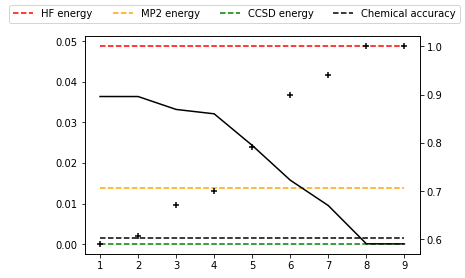

In [219]:
from matplotlib import pyplot as plt
#plt.style.use('ggplot')

fig,energy_axis = plt.subplots()
X=np.arange(1, ham_tap.n_qubits)

Y_energy=np.array(energy)-ref_energy
energy_axis.plot(X[:15], Y_energy, color='black')
energy_axis.hlines(hf_energy-ref_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(mp2_energy-ref_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(ccsd_energy-ref_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

#energy_axis.set_ylim(1e-15, 1e-0) 
#energy_axis.set_yscale('log')

score_axis = energy_axis.twinx()
Y_scores=np.array(scores)
score_axis.scatter(X, Y_scores, color='black', marker='+')

#energy_axis.set_xticks(X)

fig.legend(ncol=4)
plt.show()

In [220]:
#with open('data/score_data.json', 'r') as infile:
#    scoring_data = json.load(infile)

In [221]:
#scoring_data[speciesname] = {
#    'n_qubits_pre_taper': H_q.n_qubits, 
#    'n_qubits_post_taper': ham_tap.n_qubits,
#    'hf_energy': hf_energy,
#    'mp2_energy': mp2_energy,
#    'ccsd_energy': ccsd_energy,
#    'fci_energy': fci_energy,
#    'cs_vqe_energies': energy,
#    'stabilizer_score': scores
#}

#scoring_data

In [222]:
#with open('data/score_data.json', 'w') as outfile:
#    json.dump(scoring_data, outfile)

In [223]:
def random_stabs(n_stabs):
    Z_block = np.random.randint(0,2,(n_stabs, ham_tap.n_qubits))
    S = StabilizerOp(np.hstack([np.zeros_like(Z_block), Z_block]), np.ones(n_stabs))
    return S

def score_vs_energy(n_stabs):
    S = random_stabs(n_stabs)
    stab_score = cs_vqe_lw.basis_score(S)
    ham_cs = cs_vqe_lw.project_onto_subspace(S)
    matrix = ham_cs.to_sparse_matrix
    e = exact_gs_energy(matrix)[0]
    return stab_score, e

data={}

for n_stabs in range(1, ham_tap.n_qubits):
    print(n_stabs)
    results = []
    for i in range(250):
        try:
            results.append(score_vs_energy(n_stabs))
        except:
            pass
    data[n_stabs] = results

1
2
3
4
5
6
7
8
9


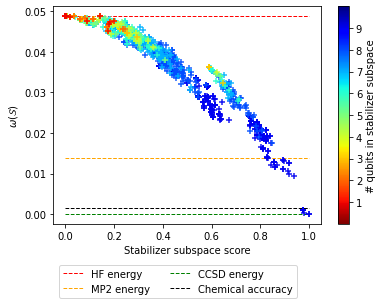

In [224]:
fig,axis = plt.subplots()

increments = []

for n_stabs,results in data.items():
    ratio = n_stabs/ham_tap.n_qubits
    increments.append(ratio)
    c = plt.cm.jet(ratio)
    X,Y = zip(*results)
    X = np.array(X)
    Y = np.array(Y) - fci_energy
    axis.scatter(
        X, 
        Y, 
        marker='+', 
        color=c, 
        zorder=n_stabs,
        alpha=0.9)
    
keys = list(data.keys())
cbar = fig.colorbar(cm.ScalarMappable(norm=Normalize(), cmap='jet_r'), 
                     ax=axis, label='# qubits in stabilizer subspace', ticks=increments)#, fraction=0.78)
cbar.ax.set_yticklabels(keys)

axis.set_xlabel('Stabilizer subspace score')
axis.set_ylabel('$\omega(\mathcal{S})$')

axis.hlines(hf_energy-fci_energy, 0, 1, ls='--', lw=1, color='red', zorder=0, label='HF energy')
axis.hlines(mp2_energy-fci_energy, 0, 1, ls='--', lw=1, color='orange', zorder=0, label='MP2 energy')
axis.hlines(ccsd_energy-fci_energy, 0, 1, ls='--', lw=1, color='green', zorder=0, label='CCSD energy')
axis.hlines(0.0016, 0, 1, ls='--', lw=1, color='black', zorder=0, label='Chemical accuracy')

fig.legend(ncol=2, bbox_to_anchor=(0.7,0))

NameError: name 'cs_data' is not defined

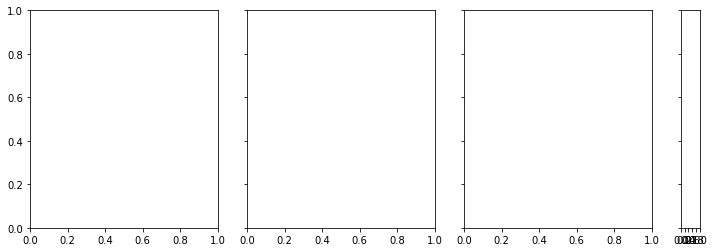

In [100]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

fig,axes = plt.subplots(1,4, sharey=True, sharex=True, 
                        gridspec_kw={'width_ratios': [10, 10, 10, 1]}, figsize=(12,4))
increments = []

def plot_data(X, axis_ind):
    axes[axis_ind].scatter(
        X, Y, 
        marker='+', 
        color=c, 
        #label = f'{ham_tap.n_qubits - stab_ind}-qubit CS-VQE', 
        zorder=stab_ind,
        alpha=0.9
    )
    axes[axis_ind].set_xlabel('Stabilizer subspace score')
    axes[axis_ind].hlines(hf_energy-fci_energy, 0, 1, ls='-', lw=1, color='red', zorder=0)
    axes[axis_ind].hlines(mp2_energy-fci_energy, 0, 1, ls='-', lw=1, color='orange', zorder=0)
    axes[axis_ind].hlines(ccsd_energy-fci_energy, 0, 1, ls='-', lw=1, color='green', zorder=0)
    axes[axis_ind].hlines(0.0016, 0, 1, ls='-', lw=1, color='black', zorder=0)

for stab_ind, data in cs_data.items():
    c_ratio = stab_ind/ham_tap.n_qubits
    increments.append(c_ratio)
    c = plt.cm.jet(c_ratio)
    X_ham, X_ucc, X_sor, Y = zip(*data)
    X_avg = [(a+b+c)/3 for a,b,c in zip(X_ham, X_ucc, X_sor)]
    X_hyb = [(a*b*c)   for a,b,c in zip(X_ham, X_ucc, X_sor)]
    Y = np.array(Y)
    Y-=fci_energy

    plot_data(X_ham, 0)
    plot_data(X_ucc, 1)
    plot_data(X_sor, 2)
    
axes[0].set_ylabel('Error [mHa]')
axes[0].set_title('Hamiltonian weighting')
axes[1].set_title('UCC weighting')
axes[2].set_title('SOR weighting')

keys = list(cs_data.keys())
cbar = fig.colorbar(cm.ScalarMappable(norm=Normalize(), cmap='jet_r'), 
                     ax=axes[3], label='# qubits in stabilizer subspace', ticks=increments, fraction=0.78)
cbar.ax.set_yticklabels(keys)

axes[3].hlines(hf_energy-fci_energy, 0, 0, ls='-', lw=1.2, color='red', label='HF energy', zorder=0)
axes[3].hlines(mp2_energy-fci_energy, 0, 0, ls='-', lw=1.2, color='orange', label='MP2 energy', zorder=0)
axes[3].hlines(ccsd_energy-fci_energy, 0, 0, ls='-', lw=1.2, color='green', label='CCSD energy', zorder=0)
axes[3].hlines(0.0016, 0, 0, ls='-', lw=1.2, color='black', label='Chemical accuracy', zorder=0)
    
axes[3].set_visible(False)    
    
fig.legend(loc="lower center", bbox_to_anchor=(.49,-.1), ncol=4)

In [ ]:
i=3
stabilizers =  find_stabilizers(n_sim_qubits=i, region=[0,ucc_sort.n_terms])
stab_score = cs_vqe_lw.basis_score(stabilizers)
scores.append(stab_score)
print('Basis score (min:0, max:1):', stab_score)
if i<10:
    ham_cs = cs_vqe_lw.project_onto_subspace(stabilizers)
    print(f'Number of qubits in contextual subspace: {ham_cs.n_qubits}/{ham_tap.n_qubits}')
    matrix = ham_cs.to_sparse_matrix
    print(exact_gs_energy(matrix)[0]-fci_energy)

In [ ]:
def stabilizers_by_term_weighting(n_terms, weighting_operator):
    preserve = weighting_operator[:n_terms]
    ZX_symp = np.hstack([preserve.Z_block, preserve.X_block])
    reduced = gf2_gaus_elim(ZX_symp)
    kernel  = gf2_basis_for_gf2_rref(reduced)
    stabilizers = StabilizerOp(kernel, np.ones(kernel.shape[0]))
    mask_diag = np.where(~np.any(stabilizers.X_block, axis=1))[0]
    return StabilizerOp(stabilizers.symp_matrix[mask_diag], stabilizers.coeff_vec[mask_diag])

def find_stabilizers(n_sim_qubits, weighting_operator=ucc_sort, region=[0, ucc_tap.n_terms]):
    print(region)
    assert(n_sim_qubits < ham_tap.n_qubits), 'Number of qubits to simulate exceeds those in the operator'
    assert(len(set(region))!=1), 'Search region collapsed without identifying any stabilizers'
    n_terms = sum(region)//2
    stabilizers = stabilizers_by_term_weighting(n_terms, weighting_operator)
    current_n_qubits = ham_tap.n_qubits - stabilizers.n_terms
    sign = np.sign(current_n_qubits - n_sim_qubits)
    print(region)
    if sign==0:
        # i.e. n_sim_qubits == current_n_qubits
        return stabilizers
    elif sign==+1:
        # i.e. n_sim_qubits < current_n_qubits
        region[1] = n_terms
    else:
        region[0] = n_terms
    return find_stabilizers(n_sim_qubits, weighting_operator, region)

def region_about_HL_gap(degree):
    HL_gap = np.where(hf_tapered==0)[0][0]
    above, below = HL_gap+degree, HL_gap-degree
    if above>hf_tapered.shape:
        above=hf_tapered.shape
    return np.arange(below, above)

def nontrivial_HL_action(degree):
    complement = np.array([i for i in np.arange(ham_tap.n_qubits) if i not in region_about_HL_gap(degree)])
    mask_nontrivial = np.where(~np.any(ham_tap.X_block[:,complement], axis=1))
    weighting = PauliwordOp(ham_tap.symp_matrix[mask_nontrivial], ham_tap.coeff_vec[mask_nontrivial]).sort(key='magnitude')
    print(weighting)
    return stabilizers_by_term_weighting(n_terms=weighting.n_terms, weighting_operator=weighting)

In [ ]:
stabilizers = nontrivial_HL_action(1)
print(stabilizers)
print('Basis score (min:0, max:1):', cs_vqe_lw.basis_score(stabilizers))
ham_cs = cs_vqe_lw.project_onto_subspace(stabilizers)
print(f'Number of qubits in contextual subspace: {ham_cs.n_qubits}/{ham_tap.n_qubits}')

In [ ]:
matrix = ham_cs.to_sparse_matrix
print(matrix.shape)
exact_gs_energy(matrix)[0] - fci_energy

In [ ]:
print(ucc_tap)